# Airbnb Study
What is it that determines the price of an Airbnb?
How often does a place get rented out? How long does the average guest stay? What are the contributing factors for these variables?
We'll look at: 
- ### Location
- ### Price
- ### Venues

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import requests
import random
!conda install -c  conda-forge geopy --yes
from geopy.geocoders import Nominatim

from IPython.display import Image
from IPython.core.display import HTML

from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

print('All installed')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    certifi-2020.12.5          |   py36h5fab9bb_0         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         378 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch

In [2]:
bnb_df = pd.read_csv('AB_NYC_2019.csv', header=0)
bnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
bnb_df.count()

id                                48895
name                              48879
host_id                           48895
host_name                         48874
neighbourhood_group               48895
neighbourhood                     48895
latitude                          48895
longitude                         48895
room_type                         48895
price                             48895
minimum_nights                    48895
number_of_reviews                 48895
last_review                       38843
reviews_per_month                 38843
calculated_host_listings_count    48895
availability_365                  48895
dtype: int64

### Filling NA values in reviews per month
The less NA values the better for data shaping

In [4]:
average_reviews_per_month = bnb_df['reviews_per_month'].mean()
average_reviews_per_month

1.3732214298586618

In [5]:
bnb_df['reviews_per_month'].fillna(value=average_reviews_per_month, inplace=True)

In [6]:
bnb_df.loc[bnb_df['reviews_per_month'].isna()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


In [7]:
bnb_df.loc[bnb_df['last_review'].isna()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1.373221,1,365
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,1.373221,2,249
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,1.373221,1,0
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,1.373221,1,365
38,11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,1.373221,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,1.373221,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,1.373221,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1.373221,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,1.373221,6,2


Renaming columns for best clarity

In [8]:
#This will help when calling column names since I know each first letter is capitalized
bnb_df.rename(columns={'host_name': 'Host Name', 'availability_365': "Availibility", "host_id":'Host ID',
                      'neighbourhood_group': 'Neighbourhood Group', 'neighbourhood': 'Neighbourhood',
                      'room_type': 'Room Type', 'minimum_night': 'Minimum Nights',
                      'number_of_reviews': 'Number of Reviews', 'last_review': 'Last Review',
                      'reviews_per_month': 'Reviews per Month',
                      'calculated_host_listings_count': 'Host Listings Count', 'minimum_nights': 'Minimum Nights'}, inplace=True)

In [9]:
#forgot a few....keeping price lowercase because of plotting, y is y, and x is X
bnb_df.rename(columns={'id':'ID', 'name':'Name', 'latitude':'Latitude', 'longitude': 'Longitude'}, inplace=True)

In [10]:
bnb_df.columns

Index(['ID', 'Name', 'Host ID', 'Host Name', 'Neighbourhood Group',
       'Neighbourhood', 'Latitude', 'Longitude', 'Room Type', 'price',
       'Minimum Nights', 'Number of Reviews', 'Last Review',
       'Reviews per Month', 'Host Listings Count', 'Availibility'],
      dtype='object')

#### Using a backwards fill to replace all NA values

In [11]:
bnb_df.fillna(method='bfill').head(5)

,ID,Name,Host ID,Host Name,Neighbourhood Group,Neighbourhood,Latitude,Longitude,Room Type,price,Minimum Nights,Number of Reviews,Last Review,Reviews per Month,Host Listings Count,Availibility
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2019-07-05,1.373221,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0


In [12]:
#Switching Last Review to datetime so I can calculate mode to fill na values
Last_Review = bnb_df['Last Review']
Last_Review = pd.to_datetime(Last_Review, infer_datetime_format=True)
bnb_df['Last Review'] = Last_Review.to_frame()

In [13]:
bnb_df['Last Review'].mode()

0   2019-06-23
dtype: datetime64[ns]

In [14]:
bnb_df.head()

,ID,Name,Host ID,Host Name,Neighbourhood Group,Neighbourhood,Latitude,Longitude,Room Type,price,Minimum Nights,Number of Reviews,Last Review,Reviews per Month,Host Listings Count,Availibility
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,1.373221,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0


In [15]:
# Maybe a forward fillinstead of replacing them with mode?
bnb_df['Last Review'].ffill()

0       2018-10-19
1       2019-05-21
2       2019-05-21
3       2019-07-05
4       2018-11-19
           ...    
48890   2019-07-08
48891   2019-07-08
48892   2019-07-08
48893   2019-07-08
48894   2019-07-08
Name: Last Review, Length: 48895, dtype: datetime64[ns]

In [16]:
#Forward will using fillna for practice and also because it filled every NaT value
bnb_df['Last Review'].fillna(method='ffill', inplace=True)

<AxesSubplot:xlabel='Number of Reviews', ylabel='price'>

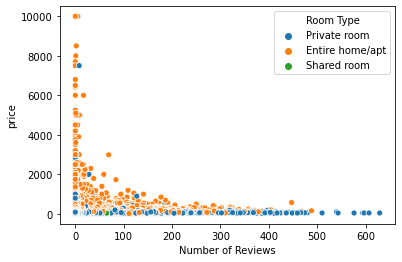

In [17]:
sns.scatterplot(data=bnb_df, x='Number of Reviews', y='price', hue='Room Type')

<AxesSubplot:xlabel='Availibility', ylabel='price'>

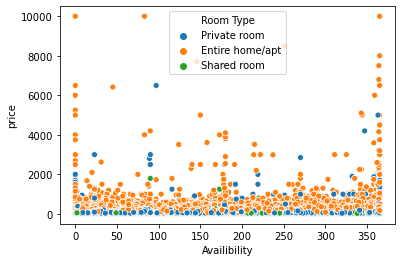

In [18]:
sns.scatterplot(data=bnb_df, x ='Availibility', y='price', hue='Room Type', sizes=(20,200))

## Looking at location to find a difference in price?
Manhattan and Brooklyn have the most listings, but do they demand highest price?

<AxesSubplot:xlabel='Neighbourhood Group', ylabel='count'>

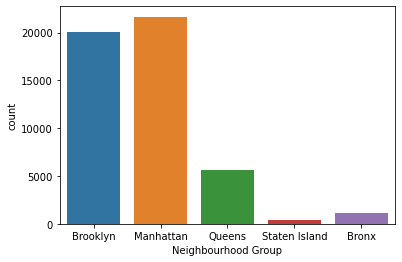

In [19]:
sns.countplot(data=bnb_df, x="Neighbourhood Group")

In [20]:
bnb_df.groupby(by='Neighbourhood Group').mean().drop(labels=['ID', 'Host ID', 'Latitude', 'Longitude'], axis=1)

,price,Minimum Nights,Number of Reviews,Reviews per Month,Host Listings Count,Availibility
Neighbourhood Group,,,,,,
Bronx,87.496792,4.560953,26.004583,1.746272,2.233731,165.758937
Brooklyn,124.383207,6.056556,24.202845,1.299585,2.284371,100.232292
Manhattan,196.875814,8.579151,20.985596,1.295601,12.791330,111.979410
Queens,99.517649,5.181433,27.700318,1.831735,4.060184,144.451818
Staten Island,114.812332,4.831099,30.941019,1.793593,2.319035,199.678284


Now, let's see the highest prices for specific Neighborhoods within the Neighbourhood Groups
---------------------
> Interestingly, Fort Wadsworth has the highest average price.
> + Even though this seems to be an outlier, we are curious as to why this price is so high.
> + We will explore ID 20305160 later


In [21]:
# we don't want to lose latitude and longitude true values by rounding so we'll only convert ID and Host ID for simplicity
top_neighbourhood_groupby = bnb_df.groupby(by="Neighbourhood", as_index=False).mean().sort_values(by='price', ascending=False).head(10)
top_neighbourhood_groupby['ID'] = top_neighbourhood_groupby['ID'].astype(int)
top_neighbourhood_groupby['Host ID'] = top_neighbourhood_groupby['Host ID'].astype(int)
top_neighbourhood_groupby.reset_index(drop=True, inplace=True)
top_neighbourhood_groupby

,Neighbourhood,ID,Host ID,Latitude,Longitude,price,Minimum Nights,Number of Reviews,Reviews per Month,Host Listings Count,Availibility
0,Fort Wadsworth,20305160,1715301,40.595460,-74.060920,800.000000,7.000000,0.000000,1.373221,3.000000,365.000000
1,Woodrow,1798271,9430973,40.538840,-74.198260,700.000000,7.000000,0.000000,1.373221,1.000000,0.000000
2,Tribeca,19694555,52744497,40.717744,-74.007400,490.638418,11.378531,11.491525,1.038677,42.971751,126.508475
3,Sea Gate,20179551,116866530,40.577119,-74.008720,487.857143,4.142857,1.428571,0.777095,1.857143,65.571429
4,Riverdale,18602901,68906782,40.887352,-73.912064,442.090909,5.363636,26.636364,1.339353,1.545455,160.818182
5,Prince's Bay,27558069,160410171,40.525700,-74.201255,409.500000,4.750000,5.750000,1.629111,1.000000,110.500000
6,Battery Park City,18310940,67655548,40.709964,-74.016585,367.557143,30.328571,8.285714,1.014422,9.442857,100.328571
7,Flatiron District,17304947,59993908,40.741052,-73.988413,341.925000,6.225000,17.737500,1.284761,7.387500,123.050000
8,Randall Manor,23293226,121565059,40.632749,-74.121504,336.000000,2.578947,18.000000,1.572971,2.473684,275.210526
9,NoHo,19080551,66588089,40.727010,-73.993052,295.717949,5.987179,12.743590,0.919122,8.628205,101.820513


In [22]:
top_neighbourhood_groupby.style.hide_columns(['ID', 'Host ID', 'Latitude', 'Longitude', 'Minimum Nights', 'Number of Reviews', 'Reviews per Month', 'Host Listings Count', 'Availibility'])
## Showing price for the presentation (screenshot)

,Neighbourhood,price
0,Fort Wadsworth,800.000000
1,Woodrow,700.000000
2,Tribeca,490.638418
3,Sea Gate,487.857143
4,Riverdale,442.090909
5,Prince's Bay,409.500000
6,Battery Park City,367.557143
7,Flatiron District,341.925000
8,Randall Manor,336.000000
9,NoHo,295.717949


Let's look at Room Type data and see if we can draw any conclusions based on the type of room one stays in.
===
The 3 different room types are:
1. Entire Home/Apt
2. Private Room
3. Shared Room

In [23]:
bnb_df['Room Type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: Room Type, dtype: int64

In [24]:
#Potentially processing data using onehotencoder 
bnb_df['Room Type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [25]:
bnb_df.groupby(by='Room Type').mean()

,ID,Host ID,Latitude,Longitude,price,Minimum Nights,Number of Reviews,Reviews per Month,Host Listings Count,Availibility
Room Type,,,,,,,,,,
Entire home/apt,1.843818e+07,6.175593e+07,40.728649,-73.960696,211.794246,8.506907,22.842418,1.319894,10.698335,111.920304
Private room,1.946893e+07,7.247514e+07,40.729208,-73.942924,89.780973,5.377900,24.112962,1.430180,3.227717,111.203933
Shared room,2.300378e+07,1.026241e+08,40.730514,-73.943343,70.127586,6.475000,16.600000,1.445062,4.662931,162.000862


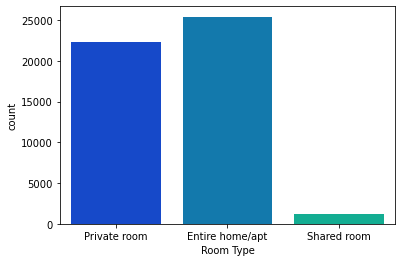

In [26]:
room_type_counplot=sns.countplot(x="Room Type", data=bnb_df, palette="winter", saturation=.8)

Using the mean from above to show average locations of Airbnb by room types

In [27]:
entire_home_apt_avglat=40.728649
entire_home_apt_avglon=-73.960696
private_room_avglat=40.729208
private_room_avglon=-73.942924
shared_room_avglat=40.730514
shared_room_avglon=-73.943343

room_type_map = folium.Map(location=[entire_home_apt_avglat, entire_home_apt_avglon], zoom_start=10)

folium.CircleMarker(location=[entire_home_apt_avglat, entire_home_apt_avglon],
                   radius=10,
                   popup="Avg Location of Entire Home",
                   color='blue',
                   fill=True,
                   fill_color='blue').add_to(room_type_map)

folium.CircleMarker(location=[private_room_avglat, private_room_avglon],
                   radius=10,
                   popup="Avg Location of Private Room",
                   color="Green",
                   fill=True,
                   fill_color="Green").add_to(room_type_map)

folium.CircleMarker(location=[shared_room_avglat, shared_room_avglon],
                   radius=10,
                   popup="Avg Location of Shared Room",
                   color="Teal",
                   fill=True,
                   fill_color="Teal").add_to(room_type_map)
room_type_map.add_child(folium.LatLngPopup())

<AxesSubplot:xlabel='Room Type', ylabel='price'>

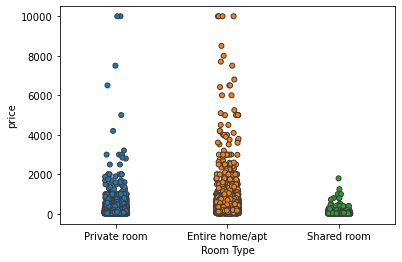

In [28]:
sns.stripplot(x=bnb_df['Room Type'], y=bnb_df['price'], data=bnb_df, orient="v", jitter=1, linewidth=1)

In [29]:
#just looking at general correlation, there is really no elements strongly correlated to price
bnb_df.corr().head(2)

,ID,Host ID,Latitude,Longitude,price,Minimum Nights,Number of Reviews,Reviews per Month,Host Listings Count,Availibility
ID,1.00000,0.58829,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.253252,0.133272,0.085468
Host ID,0.58829,1.00000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.255046,0.154950,0.203492


# Drawing maps and finding hot spots using four square

In [30]:
CLIENT_ID = 'IBAFO0SK545HXP0GU4FL1JAQ4RHQNYCKPJ1XFHSGZLJSLTKR'
CLIENT_SECRET = 'ZF23LAUMDNZVONJVZDY1DWONOZPXGUWFFOCJHHBIBD2Z31WZ'
VERSION = '20201126'
LIMIT=30

In [31]:
address = '237 W 54th St, New York, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.764509 -73.98301001135479


The top 10 neighbourhoods for the highest average priced Airbnb's
--

> There are 221 unique neighbourhoods within the 5 burroughs (neighbourhood groups).

In [32]:
top_neighbourhood_groupby_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lon, neigh in zip(top_neighbourhood_groupby['Latitude'], top_neighbourhood_groupby['Longitude'], top_neighbourhood_groupby['Neighbourhood']):
    folium.Marker(location=[lat,lon]).add_child(folium.Popup(neigh, parse_html=True)).add_to(top_neighbourhood_groupby_map)
    
top_neighbourhood_groupby_map

### We only use 500 data points for mapping Circle Markers
This sample size will help reduce an overwhelming map.
The scatter across the different parts of New York shows just how diversely spread the dataset is.


In [33]:
map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, name in zip(bnb_df['Latitude'][0:500], bnb_df['Longitude'][0:500], bnb_df['ID'][0:500].astype(str)):
    folium.features.CircleMarker(
    location=[lat,lng],
    radius=5,
    color='green',
    fill=True,
    fill_color='green',
    fill_opacity='.5',
    popup=name).add_to(map)
map

Finding the Mexican restaurants nearby and requesting the results through json

In [34]:
search_query = 'Mexican'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,latitude,longitude, VERSION, search_query, radius, LIMIT)
url


'https://api.foursquare.com/v2/venues/search?client_id=IBAFO0SK545HXP0GU4FL1JAQ4RHQNYCKPJ1XFHSGZLJSLTKR&client_secret=ZF23LAUMDNZVONJVZDY1DWONOZPXGUWFFOCJHHBIBD2Z31WZ&ll=40.764509,-73.98301001135479&v=20201126&query=Mexican&radius=500&limit=30'

In [35]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fcd7666aae4a50da4356c61'},
 'response': {'venues': [{'id': '4d0a25d08ea0a1433975e473',
    'name': 'Chipotle Mexican Grill',
    'location': {'address': '235 W 56th St',
     'crossStreet': 'West 56th & 8th Ave',
     'lat': 40.76606365605216,
     'lng': -73.9828994245716,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.76606365605216,
       'lng': -73.9828994245716}],
     'distance': 173,
     'postalCode': '10019',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['235 W 56th St (West 56th & 8th Ave)',
      'New York, NY 10019',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1c1941735',
      'name': 'Mexican Restaurant',
      'pluralName': 'Mexican Restaurants',
      'shortName': 'Mexican',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_',
       'suffix': '.png'},
      'primary': True}],
    'referralId'

Turning the results into a pandas dataframe

In [36]:
venues = results['response']['venues']

venues_df = json_normalize(venues)
venues_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id,location.neighborhood
0,4d0a25d08ea0a1433975e473,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1607300710,False,235 W 56th St,West 56th & 8th Ave,40.766064,-73.982899,"[{'label': 'display', 'lat': 40.76606365605216...",...,United States,"[235 W 56th St (West 56th & 8th Ave), New York...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4a8efd30f964a5207b1320e3,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1607300710,False,854 8th Ave Frnt 1,51st Street,40.763078,-73.985294,"[{'label': 'display', 'lat': 40.76307842113037...",...,United States,"[854 8th Ave Frnt 1 (51st Street), New York, N...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4a770a96f964a5206ee31fe3,Sombreros Mexican Restaurant,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1607300710,False,3235 NW Evangeline Trwy,NaN,40.760919,-73.981135,"[{'label': 'display', 'lat': 40.76091873649194...",...,United States,"[3235 NW Evangeline Trwy, LaFayette, NY 70507,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4b79abadf964a520f5092fe3,Cancun Mexican Restaurant,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1607300710,False,937 8th Ave,Between 56th & 55th Street,40.765728,-73.983699,"[{'label': 'display', 'lat': 40.765728, 'lng':...",...,United States,"[937 8th Ave (Between 56th & 55th Street), New...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4e7e11a28b8195460574f16f,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1607300710,False,1379 Avenue of the Americas,56th & 6th,40.763704,-73.977968,"[{'label': 'display', 'lat': 40.76370412992602...",...,United States,"[1379 Avenue of the Americas (56th & 6th), New...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
filtered_columns = ['name', 'categories'] + [col for col in venues_df.columns if col.startswith('location')] + ['id']
filtered_venues_df = venues_df.loc[:, filtered_columns]

def get_category_type(row):
    try:
        categories_list=row['categories']
    except:
        categories_list=row['venue.categories']
    
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']
    


In [38]:
filtered_venues_df['categories'] = filtered_venues_df.apply(get_category_type, axis=1)

In [39]:
filtered_venues_df.columns = [col.split('.')[-1] for col in filtered_venues_df.columns]

In [40]:
filtered_venues_df.name

0           Chipotle Mexican Grill
1           Chipotle Mexican Grill
2     Sombreros Mexican Restaurant
3        Cancun Mexican Restaurant
4           Chipotle Mexican Grill
5               Mexican Food Truck
6             Camion Mexican Truck
7                Mexican Food Cart
8         Aztec Mexican Grill Cafe
9              Fresh Mexican Grill
10           New York Mexican Food
11      Organic Mexican Food Truck
12                   Arriba Arriba
13             Antojitos Mexicanos
14               Rancho Tequileria
15                        Sombrero
Name: name, dtype: object

#### Mapping out the the Mexican venues using folium's circle marker

In [41]:
venues_map = folium.Map(location = [latitude, longitude], zoom_start=10)

folium.features.CircleMarker(
        location=[latitude, longitude],
        radius=10,
        color='red',
        popup="Conrad Midtown",
        fill=True,
        fill_color='red',
        fill_opacity=0.6).add_to(venues_map)

for lat, lng, label in zip(filtered_venues_df['lat'], filtered_venues_df['lng'], filtered_venues_df['categories']):
    folium.features.CircleMarker(
    location=[lat,lng],
    radius=5,
    color='blue',
    popup=label,
    fill=True,
    fill_color='blue',
    fill_opacity=0.6).add_to(venues_map)

venues_map

##### Using the map we found the closest Mexican venue was Camion food truck
We also want to see if this venue has a rating

In [42]:
closest_venue_id = '53eced53498ea98fb8a770e4'
closest_venue_url = 'http://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(closest_venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

closest_venue_url

'http://api.foursquare.com/v2/venues/53eced53498ea98fb8a770e4?client_id=IBAFO0SK545HXP0GU4FL1JAQ4RHQNYCKPJ1XFHSGZLJSLTKR&client_secret=ZF23LAUMDNZVONJVZDY1DWONOZPXGUWFFOCJHHBIBD2Z31WZ&v=20201126'

In [43]:
closest_venue_result = requests.get(closest_venue_url).json()
print(closest_venue_result['response']['venue'].keys())
closest_venue_result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'seasonalHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto'])


{'id': '53eced53498ea98fb8a770e4',
 'name': 'Camion Mexican Truck',
 'contact': {},
 'location': {'crossStreet': 'SE Corner of 46th & Avenue Of The Americas',
  'lat': 40.764853459986824,
  'lng': -73.98184649309732,
  'labeledLatLngs': [{'label': 'display',
    'lat': 40.764853459986824,
    'lng': -73.98184649309732}],
  'cc': 'US',
  'city': 'New York',
  'state': 'NY',
  'country': 'United States',
  'formattedAddress': ['SE Corner of 46th & Avenue Of The Americas',
   'New York, NY',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/camion-mexican-truck/53eced53498ea98fb8a770e4',
 'categories': [{'id': '4bf58dd8d48988d1cb941735',
   'name': 'Food Truck',
   'pluralName': 'Food Trucks',
   'shortName': 'Food Truck',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/streetfood_',
    'suffix': '.png'},
   'primary': True}],
 'verified': False,
 'stats': {'tipCount': 4},
 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'},
 'likes': {'count': 4,

In [44]:
try:
    print(closest_venue_result['response']['venue']['rating'])
except:
    print("This restaurant has not yet been rated")

This restaurant has not yet been rated


#### Trying another venue's rating

In [45]:
another_venue_id = '4c80589f51ada1cd734c0910'
another_venue_url = 'http://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(another_venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

another_venue_result = requests.get(another_venue_url).json()
try:
    print(another_venue_result['response']['venue']['rating'])
except:
    print("This venue has not yet been rated")

This venue has not yet been rated


### and another one...

In [46]:
third_venue_id= '4d0a25d08ea0a1433975e473'
third_venue_url = 'http://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(third_venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

third_venue_result = requests.get(third_venue_url).json()

try:
    print(third_venue_result['response']['venue']['rating'])
except:
    print("No rating yet")

7.1


In [47]:
third_venue_result['response']['venue']['tips']['count']

54

#### Let's see what the tips are of this venue. 

In [48]:
limit=60
third_venue_tips_url = 'http://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}'.format(third_venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

third_venue_tips_results = requests.get(third_venue_tips_url).json()
third_venue_tips_results

{'meta': {'code': 200, 'requestId': '5fcd766a76cc650db83643b7'},
 'response': {'tips': {'count': 54,
   'items': [{'id': '51b600bf498e34b6b1f14a71',
     'createdAt': 1370882239,
     'text': 'Relative to other locations, this one loves to skimp on all components. My advice is to be aggressive and demand more. A lot more!',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/51b600bf498e34b6b1f14a71',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agreeCount': 4,
     'disagreeCount': 0,
     'todo': {'count': 0},
     'user': {'isSanctioned': False,
      'firstName': 'Ki',
      'lastName': 'C',
      'countryCode': 'US'}}]}}}

In [49]:
third_venue_tips=third_venue_tips_results['response']['tips']['items']
third_venue_tip = third_venue_tips_results['response']['tips']['items'][0]
third_venue_tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'todo', 'user'])

In [50]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
third_venue_tips_df = json_normalize(third_venue_tips)
third_venue_tips_df

filtered_columns = ['id', 'text', 'agreeCount', 'disagreeCount', 'user.firstName', 'user.lastName']
third_venue_tips_df = third_venue_tips_df.loc[:, filtered_columns]

third_venue_tips_df

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,id,text,agreeCount,disagreeCount,user.firstName,user.lastName
0,51b600bf498e34b6b1f14a71,"Relative to other locations, this one loves to skimp on all components. My advice is to be aggressive and demand more. A lot more!",4,0,Ki,C


In [51]:
user_id = '1197248'

user_id_url= 'http://api.foursquare.com/v2/users/{}?client_id={}&client_secret={}&v={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION)

user_id_results = requests.get(user_id_url).json()
user_id_results['response']

{}

In [52]:
#missing oauth token
user_id_results

{'meta': {'code': 401,
  'errorType': 'invalid_auth',
  'errorDetail': 'Missing oauth_token. See https://developer.foursquare.com/docs/api/configuration/authentication for details.',
  'requestId': '5fcd766ae0651225f9dc63a3'},
 'response': {}}

### Exploring the location around Airbnb ID #5022 ##
The price of #5022 is $80 per night. Does having a diverse array of venues affect price?
___We're going to use Foursquare's explore endpoint to call the venue recommendations.___

In [53]:
bnb_df[bnb_df['ID']==5022]

,ID,Name,Host ID,Host Name,Neighbourhood Group,Neighbourhood,Latitude,Longitude,Room Type,price,Minimum Nights,Number of Reviews,Last Review,Reviews per Month,Host Listings Count,Availibility
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.1,1,0


In [54]:
# using Airbnb ID = 5022 lat and lng
ID_5022_lat = bnb_df.loc[4, 'Latitude']
ID_5022_lng = bnb_df.loc[4, 'Longitude']

In [55]:
ID_5022_url = 'http://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, ID_5022_lat, ID_5022_lng, VERSION, radius, LIMIT)
ID_5022_url

'http://api.foursquare.com/v2/venues/explore?client_id=IBAFO0SK545HXP0GU4FL1JAQ4RHQNYCKPJ1XFHSGZLJSLTKR&client_secret=ZF23LAUMDNZVONJVZDY1DWONOZPXGUWFFOCJHHBIBD2Z31WZ&ll=40.79851,-73.94399&v=20201126&radius=500&limit=30'

In [56]:
import requests

ID_5022_results = requests.get(ID_5022_url).json()

print('{} results around ID_5022'.format(len(ID_5022_results['response']['groups'][0]['items'])))

30 results around ID_5022


In [57]:
ID_5022_items=ID_5022_results['response']['groups'][0]['items']

>### *There are plenty of venues around ID # 5022*

In [58]:
ID_5022_df=json_normalize(ID_5022_items)

filtered_columns = ['venue.name', 'venue.categories']+[col for col in ID_5022_df.columns if col.startswith('venue.location')] +['venue.id']
ID_5022_df_filtered=ID_5022_df.loc[:, filtered_columns]

ID_5022_df_filtered['venue.categories'] = ID_5022_df_filtered.apply(get_category_type, axis = 1)

ID_5022_df_filtered.columns = [col.split(".")[-1] for col in ID_5022_df_filtered.columns]
ID_5022_df_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,neighborhood,id
0,D'Amore Winebar & Caffe,Wine Bar,118 East 116th Street,Park Ave,40.798810,-73.942320,"[{'label': 'display', 'lat': 40.798810458001206, 'lng': -73.94232005723735}]",144,US,East Harlem,NY,United States,"[118 East 116th Street (Park Ave), East Harlem, NY, United States]",NaN,NaN,52b5f1de498efe87501197dd
1,La Chula,Mexican Restaurant,137 E 116th St,NaN,40.798770,-73.941508,"[{'label': 'display', 'lat': 40.798769726275275, 'lng': -73.94150830553114}]",211,US,New York,NY,United States,"[137 E 116th St, New York, NY 10029, United States]",10029,NaN,59c6f2bda6fe4d6cb8d321a3
2,Armonie,Italian Restaurant,1649 Park Ave,117th Park Ave,40.799907,-73.942662,"[{'label': 'display', 'lat': 40.79990694458094, 'lng': -73.94266193452779}, {'label': 'entrance', 'lat': 40.799805, 'lng': -73.942565}]",191,US,New York,NY,United States,"[1649 Park Ave (117th Park Ave), New York, NY 10035, United States]",10035,NaN,51800134e4b03b4e898c8f16
3,La Marqueta,Farmers Market,1607 Park Ave,NaN,40.798686,-73.943715,"[{'label': 'display', 'lat': 40.79868636159082, 'lng': -73.94371480963098}]",30,US,New York,NY,United States,"[1607 Park Ave, New York, NY 10029, United States]",10029,NaN,4c5d9815857ca5938844cdcb
4,Urban Garden Center,Garden Center,1640 Park Ave,at 116th St.,40.799612,-73.943125,"[{'label': 'display', 'lat': 40.799611553501734, 'lng': -73.94312541492874}]",142,US,New York,NY,United States,"[1640 Park Ave (at 116th St.), New York, NY 10035, United States]",10035,NaN,4d96cb0d79b788bf58e6626a


In [59]:
list(ID_5022_df_filtered['categories'].unique())

['Wine Bar',
 'Mexican Restaurant',
 'Italian Restaurant',
 'Farmers Market',
 'Garden Center',
 'Pizza Place',
 'Coffee Shop',
 'Café',
 'Puerto Rican Restaurant',
 'Bakery',
 'Food Truck',
 'Taco Place',
 'Gym',
 'Cuban Restaurant',
 'Outdoor Sculpture',
 'Seafood Restaurant',
 'Dog Run',
 'Chinese Restaurant',
 'Thai Restaurant',
 'Discount Store',
 'Shipping Store',
 'Bank',
 'Gastropub']

___A map showing the different venues (by category) around ID_5022___
--------

In [60]:
ID_5022_map = folium.Map(location=[ID_5022_lat, ID_5022_lng], zoom_start=10)

folium.CircleMarker(location = [ID_5022_lat,ID_5022_lng],
                   radius=10,
                   popup='Airbnb ID 5022',
                   fill=True,
                   color='Red',
                   fill_color="Red",
                   fill_opacity=0.6).add_to(ID_5022_map)

for lat, lng, label in zip(ID_5022_df_filtered['lat'], ID_5022_df_filtered['lng'], ID_5022_df_filtered['categories']):
    folium.CircleMarker(location=[lat,lng],
                       radius=5,
                       popup=label,
                       fill=True,
                       color='Blue',
                       fill_color='Green',
                       fill_opacity = .9).add_to(ID_5022_map)
ID_5022_map

### Exploring _Trending_ Venues around ID #5022
+ This Airbnb seems like a good deal since there are plenty of venues nearby.


In [61]:
ID_5022_trending = 'http://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, ID_5022_lat, ID_5022_lng, VERSION)

ID_5022_trending_results = requests.get(ID_5022_trending).json()
ID_5022_trending_results

{'meta': {'code': 200, 'requestId': '5fcd766c9854b71efb1c6315'},
 'response': {'venues': []}}

In [62]:
if len(ID_5022_trending_results['response']['venues']) == 0:
    ID_5022_trending_df = 'No trending venues are available at the moment'

else:
    ID_5022_trending= ID_5022_trending_results['response']['venues']
    ID_5022_trending_df = json_normalize(ID_5022_trending)
    
    filtered_columns = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
    ID_5022_trending_df = ID_5022_trending_df.loc[:, filtered_columns]
    
    ID_5022_trending_df['categories'] = ID_5022_trending_df.apply(get_category_type, axis =1)

In [63]:
ID_5022_trending_df


'No trending venues are available at the moment'

In [64]:
if len(ID_5022_trending_results['response']['venues']) ==0:
    ID_5022_trending_df = 'No Trending Venues are avaiable at the moment!'
    
else:
    ID_5022_trending_map = folium.Map(location=[ID_5022_lat, ID_5022_lng], zoom_start=12)
    
    folium.CircleMarker(location=[ID_5022_lat, ID_5022_lng],
                        radius=10,
                        popup='Airbnb ID 5022',
                        fill=True,
                        color='lightblue',
                        fill_color='lightblue',
                        fill_opacity=.6,
                        ).add_to(ID_5022_trending_map)
    
    for lat, lng, label in zip(ID_5022_trending_df['location.lat'], ID_5022_trending_df['location.lng'], ID_5022_trending_df['name']):
        folium.CircleMarker(location=[lat,lng],
                           radius=5,
                           popup=label,
                           fill=True,
                           color='orange',
                           fill_color='orange',
                           fill_opacity=.6).add_to(ID_5022_trending_map)



In [65]:
ID_5022_trending_df

'No Trending Venues are avaiable at the moment!'

## Exploring the highest priced Airbnb profile 
> ***Since there are 3 that have charged $10000, we'll use ID 7003697's profile***

In [66]:
bnb_df[bnb_df['price']==bnb_df['price'].max()]

,ID,Name,Host ID,Host Name,Neighbourhood Group,Neighbourhood,Latitude,Longitude,Room Type,price,Minimum Nights,Number of Reviews,Last Review,Reviews per Month,Host Listings Count,Availibility
9151,7003697,Furnished room in Astoria apartment,20582832,Kathrine,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,2016-02-13,0.040000,1,0
17692,13894339,Luxury 1 bedroom apt. -stunning Manhattan views,5143901,Erin,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,2017-07-27,0.160000,1,0
29238,22436899,1-BR Lincoln Center,72390391,Jelena,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,2019-06-01,1.373221,1,83


In [67]:
#setting the latitude and longitude coordinates for ID#7003697 to create a map
ID_7003697_lat=bnb_df.iloc[9151, 6]
ID_7003697_lng=bnb_df.iloc[9151, 7]

In [68]:
ID_7003697_map = folium.Map(location=[ID_7003697_lat, ID_7003697_lng], zoom_start=12)


folium.features.RegularPolygonMarker(location=[ID_7003697_lat, ID_7003697_lng], number_of_sides=5, rotation=180, 
                                     popup='ID_7003697').add_to(ID_7003697_map)

folium.features.RegularPolygonMarker(location=[ID_5022_lat, ID_5022_lng], number_of_sides=3, rotation=180,
                                     popup='ID 5022', color='Green').add_to(ID_7003697_map)

ID_7003697_map

#### ___Pulling the url and results from Foursquare for ID_7003697___
*Let's check out the venues around this Airbnb. Are they any different than ID_5022?*

In [69]:
limit = 50
radius = 500

ID_7003697_url = 'http://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, ID_7003697_lat, ID_7003697_lng, radius, limit)
ID_7003697_url

'http://api.foursquare.com/v2/venues/explore?&client_id=IBAFO0SK545HXP0GU4FL1JAQ4RHQNYCKPJ1XFHSGZLJSLTKR&client_secret=ZF23LAUMDNZVONJVZDY1DWONOZPXGUWFFOCJHHBIBD2Z31WZ&v=20201126&ll=40.7681,-73.91651&radius=500&limit=50'

In [70]:
ID_7003697_results = requests.get(ID_7003697_url).json()

In [71]:
ID_7003697_venues = ID_7003697_results['response']['groups'][0]['items']

ID_7003697_nearby_venues = json_normalize(ID_7003697_venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
ID_7003697_nearby_venues = ID_7003697_nearby_venues.loc[:, filtered_columns]

ID_7003697_nearby_venues['venue.categories'] = ID_7003697_nearby_venues.apply(get_category_type, axis=1)

ID_7003697_nearby_venues.columns = [col.split(".")[-1] for col in ID_7003697_nearby_venues.columns]

ID_7003697_nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Favela Grill,Brazilian Restaurant,40.767348,-73.917897
1,Titan Foods Inc.,Gourmet Shop,40.769198,-73.919253
2,Off The Hook,Seafood Restaurant,40.767200,-73.918104
3,CrossFit Queens,Gym,40.769404,-73.918977
4,Orange Blossom,Gourmet Shop,40.769856,-73.917012


***The difference in average price between the neighborhood groups of ID 5022 and ID 7003697*** <br />
 *ID 5022 is in Murray Hill and ID 7003697 in Astoria*

In [72]:
bnb_df.loc[bnb_df['Neighbourhood']=='Astoria'].groupby(by='Neighbourhood').mean().style.hide_columns(['ID', 'Host ID'])

,Latitude,Longitude,price,Minimum Nights,Number of Reviews,Reviews per Month,Host Listings Count,Availibility
Neighbourhood,,,,,,,,
Astoria,40.764299,-73.920002,117.187778,6.036667,21.455556,1.292839,2.772222,109.191111


In [73]:
bnb_df.loc[bnb_df['Neighbourhood']=='Murray Hill'].groupby(by='Neighbourhood').mean().style.hide_columns(['ID', 'Host ID'])

,Latitude,Longitude,price,Minimum Nights,Number of Reviews,Reviews per Month,Host Listings Count,Availibility
Neighbourhood,,,,,,,,
Murray Hill,40.747435,-73.976029,220.958763,15.589691,9.350515,1.140620,53.865979,173.321649


Exploring 30 venues in all the neighborhoods in our dataframe
--
*We used the function from the "Neighborhoods New York" lab.*

In [74]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Host ID', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [75]:
url

'https://api.foursquare.com/v2/venues/search?client_id=IBAFO0SK545HXP0GU4FL1JAQ4RHQNYCKPJ1XFHSGZLJSLTKR&client_secret=ZF23LAUMDNZVONJVZDY1DWONOZPXGUWFFOCJHHBIBD2Z31WZ&ll=40.764509,-73.98301001135479&v=20201126&query=Mexican&radius=500&limit=30'

In [76]:
bnb_neighborhood=getNearbyVenues(names=bnb_df['Neighbourhood'].unique(), latitudes=bnb_df['Latitude'], longitudes=bnb_df['Longitude'])


Kensington
Midtown
Harlem
Clinton Hill
East Harlem
Murray Hill
Bedford-Stuyvesant
Hell's Kitchen
Upper West Side
Chinatown
South Slope
West Village
Williamsburg
Fort Greene
Chelsea
Crown Heights
Park Slope
Windsor Terrace
Inwood
East Village
Greenpoint
Bushwick
Flatbush
Lower East Side
Prospect-Lefferts Gardens
Long Island City
Kips Bay
SoHo
Upper East Side
Prospect Heights
Washington Heights
Woodside
Brooklyn Heights
Carroll Gardens
Gowanus
Flatlands
Cobble Hill
Flushing
Boerum Hill
Sunnyside
DUMBO
St. George
Highbridge
Financial District
Ridgewood
Morningside Heights
Jamaica
Middle Village
NoHo
Ditmars Steinway
Flatiron District
Roosevelt Island
Greenwich Village
Little Italy
East Flatbush
Tompkinsville
Astoria
Clason Point
Eastchester
Kingsbridge
Two Bridges
Queens Village
Rockaway Beach
Forest Hills
Nolita
Woodlawn
University Heights
Gravesend
Gramercy
Allerton
East New York
Theater District
Concourse Village
Sheepshead Bay
Emerson Hill
Fort Hamilton
Bensonhurst
Tribeca
Shore Acres

In [77]:
bnb_neighborhood.rename(columns={"Host ID": "Neighborhood"}, inplace=True)
bnb_neighborhood.groupby(by=['Neighborhood']).count()[['Venue Category']]

,Venue Category
Neighborhood,
Allerton,30
Arden Heights,30
Arrochar,30
Arverne,30
Astoria,30
...,...
Windsor Terrace,30
Woodhaven,30
Woodlawn,30


In [78]:
"There are {} Venue Categories".format(len(bnb_neighborhood['Venue Category'].unique()))

'There are 316 Venue Categories'

In [79]:
bnb_neighborhood.head(3)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kensington,40.64749,-73.97237,Der Pioneer,40.645911,-73.972028,Bakery
1,Kensington,40.64749,-73.97237,Wheated,40.646610,-73.970564,Pizza Place
2,Kensington,40.64749,-73.97237,Hinterlands Bar,40.645985,-73.972050,Dive Bar


### ***Using pandas "get_dummies" function to convert categorical variables into numerical variables***

In [80]:
bnb_neighborhood_onehot= pd.get_dummies(data=bnb_neighborhood['Venue Category'])
bnb_neighborhood_onehot['Neighborhood']=bnb_neighborhood['Neighborhood']

filtered_columns = [bnb_neighborhood_onehot.columns[-1]] + list(bnb_neighborhood_onehot.columns[:-1])
bnb_neighborhood_onehot=bnb_neighborhood_onehot[filtered_columns]
bnb_neighborhood_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Kensington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kensington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Kensington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kensington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kensington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
bnb_neighborhood_grouped = bnb_neighborhood_onehot.groupby('Neighborhood').mean().reset_index()

### Showing the frequency of the venue cateogries and how much they show up per neighborhood
> _We will then turn this into a dataframe to show the top 10 most frequent venues per neighborhood_

In [82]:
num_venues=5

for hood in bnb_neighborhood_grouped['Neighborhood']:
    print("------"+hood+"------")
    temp=bnb_neighborhood_grouped[bnb_neighborhood_grouped['Neighborhood']==hood].T.reset_index()
    temp=temp.iloc[1:]
    temp.columns=['Venue Category', 'Frequency']
    temp['Frequency']=temp['Frequency'].astype(float).round(2)
    print(temp.sort_values(by=['Frequency'], ascending=False).reset_index(drop=True).head(num_venues))
    print("\n")

------Allerton------
                    Venue Category  Frequency
0  Italian Restaurant               0.10     
1  Bookstore                        0.07     
2  Southern / Soul Food Restaurant  0.07     
3  Gift Shop                        0.03     
4  Ice Cream Shop                   0.03     


------Arden Heights------
        Venue Category  Frequency
0  Seafood Restaurant   0.07     
1  Korean Restaurant    0.07     
2  Dessert Shop         0.07     
3  Wine Bar             0.07     
4  Japanese Restaurant  0.07     


------Arrochar------
  Venue Category  Frequency
0  Coffee Shop    0.10     
1  Juice Bar      0.07     
2  Pizza Place    0.07     
3  Bookstore      0.03     
4  Pet Store      0.03     


------Arverne------
         Venue Category  Frequency
0  Deli / Bodega         0.10     
1  Café                  0.07     
2  Coffee Shop           0.07     
3  Bakery                0.07     
4  Caribbean Restaurant  0.07     


------Astoria------
      Venue Category  Freq

In [83]:
def return_most_common_venues(row, num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0: num_top_venues]

In [84]:
num_top_venues=10
columns=['Neighborhood']
indicators=['st', 'nd', 'rd']
for place in np.arange(num_top_venues):
    try:
        columns.append("{}{} Most Common Venue".format(place+1, indicators[place]))
    except:
        columns.append("{}th Most Common Venue".format(place+1))

In [85]:
bnb_neighborhood_sorted =pd.DataFrame(columns=columns)
bnb_neighborhood_sorted['Neighborhood']=bnb_neighborhood_grouped['Neighborhood']

for row in np.arange(bnb_neighborhood_grouped.shape[0]):
    bnb_neighborhood_sorted.iloc[row, 1:] = return_most_common_venues(bnb_neighborhood_grouped.iloc[row, :], num_top_venues)

#### **Dataframe showing the top 10 most commoon venues per neighborhood. Credit to Foursquare!**

In [86]:
bnb_neighborhood_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Italian Restaurant,Bookstore,Southern / Soul Food Restaurant,Art Gallery,Grocery Store,Sandwich Place,Ramen Restaurant,Juice Bar,Japanese Restaurant,Ice Cream Shop
1,Arden Heights,Japanese Restaurant,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant,Speakeasy,Greek Restaurant,Beer Bar,Gourmet Shop,Beer Store
2,Arrochar,Coffee Shop,Juice Bar,Pizza Place,Italian Restaurant,Pet Store,Breakfast Spot,Southern / Soul Food Restaurant,Cocktail Bar,Sandwich Place,Poke Place
3,Arverne,Deli / Bodega,Coffee Shop,Indian Restaurant,Fried Chicken Joint,Café,Caribbean Restaurant,Bakery,Health & Beauty Service,Southern / Soul Food Restaurant,French Restaurant
4,Astoria,Pizza Place,Café,Bar,French Restaurant,Pet Store,Candy Store,Shoe Store,Seafood Restaurant,Empanada Restaurant,Club House


### After assigning numbers (pd.get_dummies) to the different venue types to their respective neighborhoods, <br />
___we use KMEANS to cluster the neighborhoods into specfic segments of data.___
* We use 5 cluster labels
+ We will then insert these clusters into our dataframe and map them out

In [87]:
kclusters=5

bnb_grouped_clustering = bnb_neighborhood_grouped.drop('Neighborhood', 1)

kmeans=KMeans(n_clusters=kclusters, random_state=0).fit(bnb_grouped_clustering)
kmeans.labels_

array([3, 2, 1, 1, 2, 1, 3, 2, 2, 2, 3, 2, 0, 0, 1, 1, 1, 2, 1, 2, 3, 1,
       2, 2, 2, 2, 3, 0, 1, 2, 2, 2, 2, 3, 3, 1, 2, 2, 1, 3, 2, 0, 3, 1,
       2, 2, 3, 2, 2, 3, 2, 0, 1, 3, 3, 2, 1, 0, 3, 2, 0, 1, 3, 2, 1, 2,
       1, 2, 2, 2, 3, 3, 2, 3, 2, 2, 0, 0, 2, 0, 2, 1, 3, 3, 3, 0, 2, 1,
       2, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 3, 2, 2, 1, 3, 0, 1, 1,
       3, 3, 2, 3, 0, 2, 2, 3, 1, 2, 3, 0, 0, 1, 2, 0, 1, 1, 1, 1, 3, 1,
       2, 2, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 2, 3, 1, 0, 1, 1, 0, 3, 1, 2,
       2, 3, 1, 1, 2, 0, 1, 2, 3, 3, 2, 1, 2, 2, 2, 3, 3, 1, 2, 0, 3, 2,
       3, 1, 1, 0, 1, 2, 1, 1, 3, 2, 3, 1, 2, 1, 1, 3, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 0, 2, 1, 3, 1, 3, 2, 4, 2, 0, 1, 1, 2, 1, 3,
       3], dtype=int32)

In [88]:
bnb_neighborhood_sorted.insert(loc=0, column="Cluster Labels", value=kmeans.labels_)

In [89]:
bnb_neighborhood_merged=bnb_neighborhood.loc[:, ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']].groupby("Neighborhood").mean().reset_index()
bnb_neighborhood_merged=bnb_neighborhood_merged.join(other=bnb_neighborhood_sorted.set_index('Neighborhood'), on='Neighborhood')

### Dataframe with cluster labels

In [90]:
bnb_neighborhood_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,40.72298,-73.98474,3,Italian Restaurant,Bookstore,Southern / Soul Food Restaurant,Art Gallery,Grocery Store,Sandwich Place,Ramen Restaurant,Juice Bar,Japanese Restaurant,Ice Cream Shop
1,Arden Heights,40.72752,-73.98432,2,Japanese Restaurant,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant,Speakeasy,Greek Restaurant,Beer Bar,Gourmet Shop,Beer Store
2,Arrochar,40.71833,-73.95748,1,Coffee Shop,Juice Bar,Pizza Place,Italian Restaurant,Pet Store,Breakfast Spot,Southern / Soul Food Restaurant,Cocktail Bar,Sandwich Place,Poke Place
3,Arverne,40.68373,-73.92377,1,Deli / Bodega,Coffee Shop,Indian Restaurant,Fried Chicken Joint,Café,Caribbean Restaurant,Bakery,Health & Beauty Service,Southern / Soul Food Restaurant,French Restaurant
4,Astoria,40.72004,-73.99104,2,Pizza Place,Café,Bar,French Restaurant,Pet Store,Candy Store,Shoe Store,Seafood Restaurant,Empanada Restaurant,Club House


**Mapping the neighborhoods out and using a color array to identify which cluster each neighborhood is a part of.**

In [91]:
bnb_map_clusters= folium.Map(location=[latitude, longitude], zoom_start=11)
x=np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1), len(ys))
rainbow=[colors.rgb2hex(i) for i in colors_array]

markers_colors=[]
for lat, lon, neigh, cluster in zip(bnb_neighborhood_merged['Neighborhood Latitude'],
                                  bnb_neighborhood_merged['Neighborhood Longitude'],
                                  bnb_neighborhood_merged['Neighborhood'],
                                  bnb_neighborhood_merged['Cluster Labels']):
    
    label = folium.Popup(str(neigh)+ " "+ 'Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(location=[lat, lon], radius=5,
                       popup=label,
                       color=rainbow[cluster-1],
                       fill=True,
                       fill_color=rainbow[cluster-1],
                       fill_opacity=.8).add_to(bnb_map_clusters)
bnb_map_clusters

### All neighbourhoods in cluster 0

In [92]:
bnb_neighborhood_merged.loc[bnb_neighborhood_merged['Cluster Labels']==0, bnb_neighborhood_merged.columns[[0]+list(range(5, bnb_neighborhood_merged.shape[1]))]]


,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Bayswater,Coffee Shop,Brewery,Italian Restaurant,Restaurant,Dog Run,Salon / Barbershop,Cocktail Bar,Bakery,Southern / Soul Food Restaurant
13,Bedford-Stuyvesant,Bar,Pizza Place,Wine Shop,Juice Bar,Health & Beauty Service,Cocktail Bar,Gym / Fitness Center,Grocery Store,Gastropub
27,Bull's Head,Cocktail Bar,Coffee Shop,Yoga Studio,Pizza Place,Park,Sandwich Place,French Restaurant,Furniture / Home Store,Boutique
41,Clinton Hill,Taco Place,Wine Shop,Bakery,Cocktail Bar,Garden,Southern / Soul Food Restaurant,Record Shop,Pub,Pizza Place
51,Crown Heights,Mexican Restaurant,Pizza Place,Gym,Coffee Shop,Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Liquor Store,New American Restaurant
57,Downtown Brooklyn,Mexican Restaurant,Pub,Bagel Shop,Pizza Place,Wine Shop,Gym,Pie Shop,Comic Shop,Salon / Barbershop
60,East Flatbush,Cocktail Bar,American Restaurant,Gourmet Shop,Thrift / Vintage Store,Indian Restaurant,Yoga Studio,Irish Pub,Spa,Sandwich Place
76,Flatlands,Gym,Mexican Restaurant,Wine Shop,Coffee Shop,Pizza Place,Bagel Shop,Italian Restaurant,Salon / Barbershop,Greek Restaurant
77,Flushing,Mexican Restaurant,French Restaurant,Record Shop,Cocktail Bar,Italian Restaurant,Bakery,Gourmet Shop,Park,Bookstore
79,Forest Hills,Cocktail Bar,Coffee Shop,Thai Restaurant,Yoga Studio,Sushi Restaurant,Beer Bar,Mexican Restaurant,Garden Center,Café


### All neighbourhoods in cluster 1

In [93]:
bnb_neighborhood_merged.loc[bnb_neighborhood_merged['Cluster Labels']==1, bnb_neighborhood_merged.columns[[0]+list(range(5, bnb_neighborhood_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Arrochar,Juice Bar,Pizza Place,Italian Restaurant,Pet Store,Breakfast Spot,Southern / Soul Food Restaurant,Cocktail Bar,Sandwich Place,Poke Place
3,Arverne,Coffee Shop,Indian Restaurant,Fried Chicken Joint,Café,Caribbean Restaurant,Bakery,Health & Beauty Service,Southern / Soul Food Restaurant,French Restaurant
5,Bath Beach,Coffee Shop,Bar,American Restaurant,Bakery,Brazilian Restaurant,New American Restaurant,Mexican Restaurant,Ethiopian Restaurant,Peruvian Restaurant
14,Belle Harbor,Mexican Restaurant,Thai Restaurant,Park,Convenience Store,Pizza Place,Donut Shop,Cocktail Bar,Performing Arts Venue,Gym
15,Bellerose,Ice Cream Shop,Gym / Fitness Center,Yoga Studio,Flower Shop,Scenic Lookout,Pool,Pier,Music Venue,Massage Studio
...,...,...,...,...,...,...,...,...,...,...
207,West Brighton,Coffee Shop,Opera House,Performing Arts Venue,Yoga Studio,Dance Studio,Bookstore,Sushi Restaurant,Spa,Café
209,West Village,Bakery,Vegetarian / Vegan Restaurant,Burger Joint,Coffee Shop,Italian Restaurant,Juice Bar,Gym,Gift Shop,Dance Studio
215,Willowbrook,Vegetarian / Vegan Restaurant,Tea Room,Dessert Shop,Coffee Shop,Organic Grocery,Sake Bar,Toy / Game Store,Chinese Restaurant,Seafood Restaurant
216,Windsor Terrace,Yoga Studio,Mediterranean Restaurant,Sushi Restaurant,Salon / Barbershop,Bike Shop,Grocery Store,Miscellaneous Shop,Fast Food Restaurant,Pharmacy


### All neighbourhoods in cluster 2

In [94]:
bnb_neighborhood_merged.loc[bnb_neighborhood_merged['Cluster Labels']==2, bnb_neighborhood_merged.columns[[0] + list(range(5,bnb_neighborhood_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arden Heights,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant,Speakeasy,Greek Restaurant,Beer Bar,Gourmet Shop,Beer Store
4,Astoria,Café,Bar,French Restaurant,Pet Store,Candy Store,Shoe Store,Seafood Restaurant,Empanada Restaurant,Club House
7,Bay Ridge,Spanish Restaurant,Mobile Phone Shop,Bar,Bakery,Music Venue,Grocery Store,Coffee Shop,Salad Place,Bike Rental / Bike Share
8,Bay Terrace,Yoga Studio,Bar,Cocktail Bar,Coffee Shop,Mexican Restaurant,Gymnastics Gym,Restaurant,Record Shop,New American Restaurant
9,"Bay Terrace, Staten Island",Italian Restaurant,Bakery,Cosmetics Shop,Food Truck,Dog Run,Farmers Market,Café,Garden Center,Taco Place
...,...,...,...,...,...,...,...,...,...,...
204,Vinegar Hill,Bar,Bakery,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Garden,Scenic Lookout,Park,Mexican Restaurant
206,Washington Heights,Mexican Restaurant,Yoga Studio,Pizza Place,Cocktail Bar,Latin American Restaurant,School,Sandwich Place,Pub,Park
211,Westerleigh,Lounge,Baseball Field,Sandwich Place,Mexican Restaurant,Track,Track Stadium,Bar,Park,Theme Restaurant
213,Williamsbridge,Pizza Place,Park,Bar,Dog Run,Fried Chicken Joint,Spa,Seafood Restaurant,Garden,Coffee Shop


### All neighbourhoods in cluster 3

In [95]:
bnb_neighborhood_merged.loc[bnb_neighborhood_merged['Cluster Labels']==3, bnb_neighborhood_merged.columns[[0] + list(range(5,bnb_neighborhood_merged.shape[1]))]]                                                                      

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Bookstore,Southern / Soul Food Restaurant,Art Gallery,Grocery Store,Sandwich Place,Ramen Restaurant,Juice Bar,Japanese Restaurant,Ice Cream Shop
6,Battery Park City,Coffee Shop,Thai Restaurant,Bar,Pizza Place,Record Shop,Yoga Studio,Brewery,Dog Run,Food & Drink Shop
10,Baychester,Italian Restaurant,Cocktail Bar,Sushi Restaurant,Eastern European Restaurant,Salad Place,Playground,Pilates Studio,Health Food Store,Greek Restaurant
20,Borough Park,Pizza Place,Italian Restaurant,Café,Playground,Tapas Restaurant,Bakery,Bar,Boutique,Diner
26,Brownsville,Juice Bar,Salon / Barbershop,Garden,Bookstore,Gift Shop,Pizza Place,Deli / Bodega,Dessert Shop,Café
33,Castleton Corners,Italian Restaurant,Café,Pizza Place,Playground,Thai Restaurant,Asian Restaurant,Bakery,Boutique,Diner
34,Chelsea,Cocktail Bar,Park,Gourmet Shop,Coffee Shop,Boutique,Breakfast Spot,Café,Candy Store,Board Shop
39,Clason Point,Italian Restaurant,Hotel,Gym / Fitness Center,Fast Food Restaurant,Seafood Restaurant,Cocktail Bar,Coffee Shop,Dessert Shop,Pizza Place
42,Co-op City,Art Gallery,Cocktail Bar,Coffee Shop,Hotel,Women's Store,Street Art,Steakhouse,Restaurant,Pilates Studio
46,Concord,Italian Restaurant,Hotel,Gym / Fitness Center,Fast Food Restaurant,Seafood Restaurant,Cocktail Bar,Coffee Shop,Dessert Shop,Pizza Place


### All neighbourhoods in cluster 4

In [96]:
bnb_neighborhood_merged.loc[bnb_neighborhood_merged['Cluster Labels']==4, bnb_neighborhood_merged.columns[[0] + list(range(5, bnb_neighborhood_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
212,Whitestone,Playground,Cosmetics Shop,Park,Yoga Studio,Escape Room,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant


*Distribution plot of clusters*

<AxesSubplot:xlabel='Cluster Labels'>

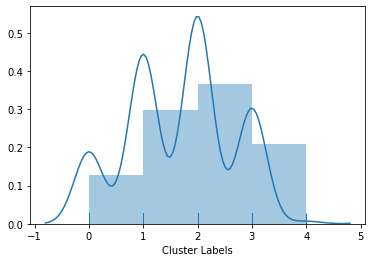

In [97]:
sns.distplot(a=bnb_neighborhood_merged['Cluster Labels'], bins=4, kde=True, label="Dist Plot", rug=True)

Rearraning columns to make it look nice. Then, plot out the Clusters on a box plot and swarm plot. <br /> 
**Can we draw any conclusions from the clustering method?** <br />


In [98]:
bnb_neighborhood_prices=bnb_df.groupby(by='Neighbourhood').mean().drop(labels=['ID', 'Host ID', 'Latitude', 'Minimum Nights', 'Number of Reviews', 'Reviews per Month', 'Host Listings Count', 'Availibility', 'Longitude'], axis=1).reset_index()
bnb_neighborhood_prices.rename(columns={'Neighbourhood':"Neighborhood"}, inplace=True)


In [116]:
bnb_neighborhood_merged_prices=bnb_neighborhood_merged.set_index(
    'Neighborhood').join(other=bnb_neighborhood_prices.set_index('Neighborhood'), on='Neighborhood', how='inner')

In [130]:
bnb_neighborhood_merged_prices.iloc[:, 0:13]

,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,
Allerton,40.72298,-73.98474,3,Italian Restaurant,Bookstore,Southern / Soul Food Restaurant,Art Gallery,Grocery Store,Sandwich Place,Ramen Restaurant,Juice Bar,Japanese Restaurant,Ice Cream Shop
Arden Heights,40.72752,-73.98432,2,Japanese Restaurant,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant,Speakeasy,Greek Restaurant,Beer Bar,Gourmet Shop,Beer Store
Arrochar,40.71833,-73.95748,1,Coffee Shop,Juice Bar,Pizza Place,Italian Restaurant,Pet Store,Breakfast Spot,Southern / Soul Food Restaurant,Cocktail Bar,Sandwich Place,Poke Place
Arverne,40.68373,-73.92377,1,Deli / Bodega,Coffee Shop,Indian Restaurant,Fried Chicken Joint,Café,Caribbean Restaurant,Bakery,Health & Beauty Service,Southern / Soul Food Restaurant,French Restaurant
Astoria,40.72004,-73.99104,2,Pizza Place,Café,Bar,French Restaurant,Pet Store,Candy Store,Shoe Store,Seafood Restaurant,Empanada Restaurant,Club House
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Windsor Terrace,40.74192,-73.99501,1,Gym / Fitness Center,Yoga Studio,Mediterranean Restaurant,Sushi Restaurant,Salon / Barbershop,Bike Shop,Grocery Store,Miscellaneous Shop,Fast Food Restaurant,Pharmacy
Woodhaven,40.81618,-73.94894,2,Boutique,French Restaurant,Yoga Studio,Event Space,Sushi Restaurant,Music Venue,Food & Drink Shop,Spa,Café,Chinese Restaurant
Woodlawn,40.75979,-73.99119,1,Burger Joint,Juice Bar,Gift Shop,Theater,Bakery,Coffee Shop,Indie Theater,Wine Shop,American Restaurant,Resort


## Making sure price is viewable. Let's plot it out.

In [159]:
bnb_neighborhood_merged_columns=bnb_neighborhood_merged_prices.columns.tolist()
bnb_neighborhood_merged_columns=bnb_neighborhood_merged_columns[:3]+bnb_neighborhood_merged_columns[-1:]+bnb_neighborhood_merged_columns[4:-1]

In [165]:
bnb_neighborhood_merged_prices=bnb_neighborhood_merged_prices[bnb_neighborhood_merged_columns]
bnb_neighborhood_merged_prices.head()

,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,price,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,
Allerton,40.72298,-73.98474,3,87.595238,Bookstore,Southern / Soul Food Restaurant,Art Gallery,Grocery Store,Sandwich Place,Ramen Restaurant,Juice Bar,Japanese Restaurant,Ice Cream Shop
Arden Heights,40.72752,-73.98432,2,67.250000,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant,Speakeasy,Greek Restaurant,Beer Bar,Gourmet Shop,Beer Store
Arrochar,40.71833,-73.95748,1,115.000000,Juice Bar,Pizza Place,Italian Restaurant,Pet Store,Breakfast Spot,Southern / Soul Food Restaurant,Cocktail Bar,Sandwich Place,Poke Place
Arverne,40.68373,-73.92377,1,171.779221,Coffee Shop,Indian Restaurant,Fried Chicken Joint,Café,Caribbean Restaurant,Bakery,Health & Beauty Service,Southern / Soul Food Restaurant,French Restaurant
Astoria,40.72004,-73.99104,2,117.187778,Café,Bar,French Restaurant,Pet Store,Candy Store,Shoe Store,Seafood Restaurant,Empanada Restaurant,Club House


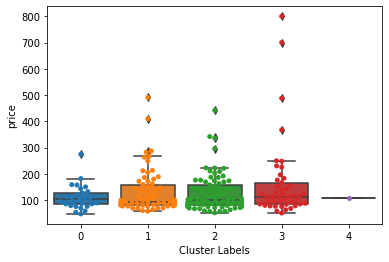

In [204]:
ax = sns.boxplot(x='Cluster Labels', y='price', data=bnb_neighborhood_merged_prices)
ax = sns.swarmplot(x='Cluster Labels', y='price', data=bnb_neighborhood_merged_prices, orient='v')

In [215]:
bnb_neighborhood_merged_prices.groupby("Cluster Labels").mean().reset_index()

,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,price
0,0,40.693026,-73.961620,110.774461
1,1,40.731583,-73.966168,131.437588
2,2,40.744192,-73.954897,126.149557
3,3,40.715383,-73.979981,163.237593
4,4,40.740280,-73.831680,107.545455
